In [30]:
from config_voting import *
from nms import nms
from VOCap import VOCap
from copy import *
from itertools import compress

model_category= 'car'
category = 'carbus'
category_ls = ['car','bus']
set_type = 'test'
'''
if category=='all':
    category_ls = all_categories
else:
    category_ls =[category]
'''    
img_list_all = []
for category_i in category_ls:
    file_list = Dataset['{0}_list'.format(set_type)].format(category_i)
    assert(os.path.isfile(file_list))
    
    with open(file_list, 'r') as fh:
        content = fh.readlines()
    
    img_list_i = [x.strip().split() for x in content]
    img_num_i = len(img_list_i)
    print('total number of images for {1}: {0}'.format(img_num_i, category_i))
    
    for ll in img_list_i:
        ll.append(category_i)
        
    img_list_all += deepcopy(img_list_i)
    
    if category_i==model_category:
        img_list = deepcopy(img_list_i)
        img_num = len(img_list)
    
        
img_num_all = len(img_list_all)
print('total number of images for {1}: {0}'.format(img_num_all, 'all'))

total number of images for car: 1000
total number of images for bus: 498
total number of images for all: 1498


In [31]:
dir_img = Dataset['img_dir'].format(model_category)
dir_anno = Dataset['anno_dir'].format(model_category)

file_gt_obj_anno = os.path.join(dir_perf_eval, 'gt_anno_{0}_{1}_{2}.pickle'.format(model_category, dataset_suffix, set_type))
assert(os.path.isfile(file_gt_obj_anno))
with open(file_gt_obj_anno, 'rb') as fh:
    gt, n_pos = pickle.load(fh)
    
assert(img_num==len(gt))

if category!='all':
    file_det_result = os.path.join(dir_det_result, 'props_det_{0}_{1}_pctl33.pickle'.format(model_category, 'carbus'))
    with open(file_det_result, 'rb') as fh:
        det = pickle.load(fh)
        
    # for dd in det:
    #     dd['cat']=category
            
else:
    all_rst_file = os.path.join(dir_det_result,'all_score_nms_list.pickle')
    assert(os.path.isfile(all_rst_file))
    with open(all_rst_file, 'rb') as fh:
        score_rst, score_rst2, nms_list_all, nms_list_all2, det = pickle.load(fh)

    assert(img_num_all == len(score_rst))
        

'''
if category!='all':
    msk = [dd['cat']==category for dd in det]
    score_rst = list(compress(score_rst, msk))
    score_rst2 = list(compress(score_rst2, msk))
    nms_list_all = list(compress(nms_list_all, msk))
    nms_list_all2 = list(compress(nms_list_all2, msk))
    det = list(compress(det, msk))
    
'''

boxes = np.zeros((4,0))
scores = []
img_ids = []
img_ids_all = []
n_obj=0
for nn in range(img_num_all):
    num_bbox = det[nn]['box'].shape[0]
    # s_i = score_rst2[nn][:,all_categories.index(model_category)]
    s_i = det[nn]['score']
    b_i = det[nn]['box']
    # adhoc thing
    
    si = np.argsort(-s_i)
    hhi, wwi = det[nn]['img_siz']
    topn = 5
    bbox_area = np.zeros(topn)
    for mm in range(topn):
        bbmm = b_i[si[mm]]
        bbmm = [max(math.ceil(bbmm[0]), 1), max(math.ceil(bbmm[1]), 1), \
                min(math.floor(bbmm[2]), wwi), min(math.floor(bbmm[3]), hhi)]
        bbox_area[mm] = (bbmm[2]-bbmm[0])*(bbmm[3]-bbmm[1])

    biggest_i = np.argmax(bbox_area)
    s_i[si[biggest_i]] += 100
    
    nms_list = nms(np.column_stack([b_i, s_i]), nms_thrh)
    # nms_list = nms_list_all2[nn]
    boxes = np.column_stack([boxes, b_i[nms_list, :].T])
    scores = np.append(scores, s_i[nms_list])
    
    img_ids_all = np.append(img_ids_all, np.ones(len(nms_list))*nn).astype(int)
    
    if det[nn]['cat']==model_category:
        img_ids = np.append(img_ids, np.ones(len(nms_list))*n_obj).astype(int)
        n_obj += 1
    else:
        img_ids = np.append(img_ids, np.ones(len(nms_list))*-1).astype(int)
        
    if nn%200==0:
        print(nn, end=' ')
        sys.stdout.flush()

0 200 400 600 800 1000 1200 1400 

In [32]:
print(' ')
assert(img_num==n_obj)

print('evaluate P-R curve and AP ...')

si = np.argsort(-scores)
img_ids = img_ids[si]
img_ids_all = img_ids_all[si]
boxes = boxes[:, si]

nd = len(scores)
tp = np.zeros(nd)
fp = np.zeros(nd)

d1 = -1

 
evaluate P-R curve and AP ...


In [75]:
for dd in range(d1+1, nd):
    ii = img_ids[dd]
    if ii == -1:
        fp[dd] = 1
    else:
        bb = boxes[:, dd]
        ovmax = -np.inf
        jmax = []
        for jj in range(gt[ii]['bbox'].shape[1]):
            bbgt = gt[ii]['bbox'][:,jj]
            bi = [max(bb[0], bbgt[0]), max(bb[1], bbgt[1]), min(bb[2], bbgt[2]), min(bb[3], bbgt[3])]
            iw = bi[2]-bi[0]+1
            ih = bi[3]-bi[1]+1
            if iw>0 and ih>0:
                ua = (bb[2]-bb[0]+1)*(bb[3]-bb[1]+1)+\
                     (bbgt[2]-bbgt[0]+1)*(bbgt[3]-bbgt[1]+1)-\
                     iw*ih
                ov = iw*ih/ua
                if ov>ovmax:
                    ovmax=ov
                    jmax=jj
                
        if ovmax >= Eval_ov_thrh:
            if not gt[ii]['diff'][jmax]:
                if not gt[ii]['det'][jmax]:
                    tp[dd]=1
                    gt[ii]['det'][jmax] = True
                else:
                    fp[dd]=1
                    
        else:
            fp[dd]=1
            
    if fp[dd]==1:
        d1 = dd
        break
        
print(dd, img_ids[dd], img_ids_all[dd])

476 654 654


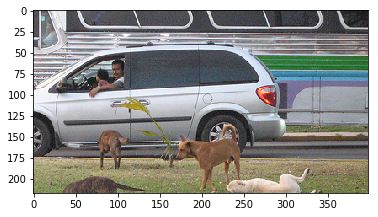

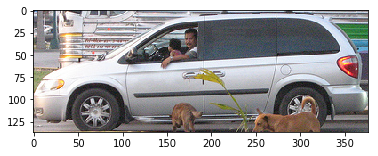

In [76]:
import matplotlib.pyplot as plt

n = img_ids[dd]
n2 = img_ids_all[dd]
bbox = boxes[:,dd]

if n>-1:
    img_name = img_list[n][0]
    img_name2 = img_list_all[n2][0]
    assert(img_name == img_name2)
    assert(img_list_all[n2][2]==model_category)
    
    file_img = os.path.join(dir_img, '{0}.JPEG'.format(img_name))
    img = cv2.imread(file_img)
    height, width = img.shape[0:2]
    bbox = [max(math.ceil(bbox[0]), 1), max(math.ceil(bbox[1]), 1), \
            min(math.floor(bbox[2]), width), min(math.floor(bbox[3]), height)]
    img1 = img[bbox[1]-1:bbox[3], bbox[0]-1:bbox[2],:]
    plt.imshow(img1[...,::-1])
    plt.show()
    
    gtbox = gt[n]['bbox'][:,0]
    gtbox = [max(math.ceil(gtbox[0]), 1), max(math.ceil(gtbox[1]), 1), \
            min(math.floor(gtbox[2]), width), min(math.floor(gtbox[3]), height)]
    img2 = img[gtbox[1]-1:gtbox[3], gtbox[0]-1:gtbox[2],:]
    plt.imshow(img2[...,::-1])
    plt.show()
else:
    img_name = img_list_all[n2][0]
    dir_img_oo = Dataset['img_dir'].format(img_list_all[n2][2])
    file_img = os.path.join(dir_img_oo, '{0}.JPEG'.format(img_name))
    img = cv2.imread(file_img)
    height, width = img.shape[0:2]
    bbox = [max(math.ceil(bbox[0]), 1), max(math.ceil(bbox[1]), 1), \
            min(math.floor(bbox[2]), width), min(math.floor(bbox[3]), height)]
    img1 = img[bbox[1]-1:bbox[3], bbox[0]-1:bbox[2],:]
    plt.imshow(img1[...,::-1])
    plt.show()
    
    

In [11]:
print(file_img)
print(img_list[n][0])
!ls /export/home/qliu24/qing_voting_data/dataset/PASCAL3D+_release1.1/Images/car_imagenet/

/export/home/qliu24/dataset/PASCAL3D+_release1.1/Images/car_imagenet/n03770679_7694.JPEG
n03770679_7694
ls: cannot access /export/home/qliu24/qing_voting_data/dataset/PASCAL3D+_release1.1/Images/car_imagenet/: No such file or directory


In [12]:
import glob

props_list = glob.glob(os.path.join(Feat['cache_dir'], \
               'props_feat_{0}_{1}_{2}_*.pickle'.format('car', dataset_suffix, set_type)))
print(props_list)

['/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_6.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_3.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_4.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_2.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_5.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_8.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_7.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_9.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_rand_test_1.pickle', '/export/home/qliu24/qing_voting_data/intermediate/feat/props_feat_car_mergelist_

In [23]:
file_list = Dataset['{0}_list'.format(set_type)].format('car')
with open(file_list, 'r') as fh:
    content = fh.readlines()
    
img_list_i= [x.strip().split() for x in content]
img_list_i[n]

['n03498781_6455', '1']

In [6]:
fp = np.cumsum(fp)
tp = np.cumsum(tp)
rec = tp/n_pos
prec = tp/(tp+fp)

ap = VOCap(rec, prec)
print('  AP = %3.1f'%(ap*100))

  AP = 23295.4
